In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import kn  # Modified Bessel function
import time

In [5]:

def simulate_leptogenesis(M=1e13, epsilon=1e-6, K=10.0, z_range=(0.1, 100.0), verbose=True):
    """
    Highly optimized simulation of leptogenesis with the given parameters
    """
    start_time = time.time()
    if verbose:
        print(f"  Simulating with M={M:.1e}, ε={epsilon:.1e}, K={K:.1f}...")
    
    # Constants
    g_star = 106.75  # Effective degrees of freedom (Standard Model at high T)
    M_pl = 1.22e19  # Planck mass in GeV
    sphaleron_conversion = 28/79  # Conversion factor from lepton to baryon asymmetry
    
    z_initial, z_final = z_range
    
    # Precomputed constants
    H_z1 = np.sqrt(g_star * np.pi**2 / 30) * M**2 / M_pl
    Y_N_eq_prefactor = 45 / (4 * np.pi**4 * g_star)
    
    # Functions for the Boltzmann equations - optimized for speed
    def H(z):
        """Hubble parameter as a function of z = M/T"""
        return H_z1 / (z**2)

    def Y_N_eq(z):
        """Equilibrium density of heavy neutrinos - optimized with approximations"""
        # Non-relativistic approximation for z > 3
        if isinstance(z, np.ndarray):
            result = np.zeros_like(z)
            # For z > 3, use non-relativistic approximation: Y_N_eq ∝ z^(3/2) * exp(-z)
            high_z = z > 3
            result[high_z] = Y_N_eq_prefactor * z[high_z]**(3/2) * np.exp(-z[high_z])
            
            # For z < 3, use simplified Bessel function calculation
            low_z = ~high_z
            if np.any(low_z):
                for i, z_val in enumerate(z[low_z]):
                    idx = np.arange(len(z))[low_z][i]
                    result[idx] = Y_N_eq_prefactor * z_val**2 * kn(2, z_val)
            return result
        else:
            if z > 3:
                return Y_N_eq_prefactor * z**(3/2) * np.exp(-z)
            else:
                return Y_N_eq_prefactor * z**2 * kn(2, z)

    def boltzmann_equations(z, Y):
        """System of Boltzmann equations - optimized for speed"""
        Y_N, Y_L = Y
        
        # Calculate parameters only once
        hz = H(z)
        gamma_D_val = K * H_z1 * M / z  # Decay rate
        Y_N_eq_val = Y_N_eq(z)
        
        # Equation for Y_N - safely handle potential division by zero
        if Y_N_eq_val > 0:
            dY_N_dz = -z/hz * (Y_N/Y_N_eq_val - 1) * gamma_D_val
        else:
            dY_N_dz = -z/hz * gamma_D_val * Y_N
        
        # Calculate washout rate
        if Y_N_eq_val > 0:
            gamma_W_val = gamma_D_val * np.exp(-z) * z**(3/2) / Y_N_eq_val
        else:
            gamma_W_val = 0
        
        # Equation for Y_L
        dY_L_dz = epsilon * z/hz * (Y_N/Y_N_eq_val - 1) * gamma_D_val - z/hz * gamma_W_val * Y_L
        
        return [dY_N_dz, dY_L_dz]

    # Initial conditions
    Y_N_initial = Y_N_eq(z_initial)  # Start in equilibrium
    Y_L_initial = 0.0  # No initial lepton asymmetry

    # Solve with fewer evaluation points and stiff solver
    z_span = (z_initial, z_final)
    z_eval = np.logspace(np.log10(z_initial), np.log10(z_final), 200)  # Reduced from 1000 to 200

    # Use BDF method which is better for stiff problems
    solution = solve_ivp(
        boltzmann_equations, 
        z_span, 
        [Y_N_initial, Y_L_initial], 
        method='BDF',      # Better for stiff problems
        t_eval=z_eval,
        rtol=1e-3,         # Further relaxed tolerance
        atol=1e-6,         # Further relaxed tolerance
        max_step=10.0      # Allow larger steps
    )

    # Extract results
    z_values = solution.t
    Y_N_values = solution.y[0]
    Y_L_values = solution.y[1]
    
    # Calculate final baryon asymmetry
    final_lepton_asymmetry = Y_L_values[-1]
    final_baryon_asymmetry = -sphaleron_conversion * final_lepton_asymmetry
    
    elapsed = time.time() - start_time
    if verbose:
        print(f"  Done in {elapsed:.2f} seconds. Final baryon asymmetry: {final_baryon_asymmetry:.2e}")
    
    # Return only essential results to save memory
    return {
        'z_values': z_values,
        'Y_N_values': Y_N_values,
        'Y_L_values': Y_L_values,
        'final_lepton_asymmetry': final_lepton_asymmetry,
        'final_baryon_asymmetry': final_baryon_asymmetry,
        'parameters': {
            'M': M,
            'epsilon': epsilon,
            'K': K,
        }
    }

# Run a quick parameter scan to study the effect of the CP asymmetry
def quick_cp_asymmetry_scan(epsilons=None, M=1e13, K=10.0, z_range=(0.1, 100.0)):
    """Study the effect of different CP asymmetry values - optimized for speed"""
    if epsilons is None:
        # Use fewer points by default
        epsilons = [1e-7, 1e-6, 1e-5]
    
    print(f"Running CP asymmetry scan with {len(epsilons)} values...")
    start_time = time.time()
    
    results = []
    for eps in epsilons:
        result = simulate_leptogenesis(M=M, epsilon=eps, K=K, z_range=z_range)
        results.append(result)
    
    elapsed = time.time() - start_time
    print(f"CP asymmetry scan completed in {elapsed:.2f} seconds!")
    
    # Plot Y_L for different epsilon values
    plt.figure(figsize=(10, 5))
    for i, result in enumerate(results):
        plt.semilogx(result['z_values'], result['Y_L_values'], 
                    label=f"ε = {epsilons[i]:.2e}")
    
    plt.xlabel('z = M/T')
    plt.ylabel('Y_L')
    plt.title('Lepton Asymmetry for Different CP Asymmetry Values')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot final baryon asymmetry vs. epsilon
    final_YB_values = [result['final_baryon_asymmetry'] for result in results]
    
    plt.figure(figsize=(8, 5))
    plt.loglog(epsilons, np.abs(final_YB_values), 'o-')
    plt.axhline(y=6e-10, color='r', linestyle='--', label='Observed (~6e-10)')
    
    plt.xlabel('CP Asymmetry (ε)')
    plt.ylabel('Final Baryon Asymmetry |Y_B|')
    plt.title('Final Baryon Asymmetry vs. CP Asymmetry')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return results

# Run a quick parameter scan to study the effect of the washout strength
def quick_washout_scan(Ks=None, M=1e13, epsilon=1e-6, z_range=(0.1, 100.0)):
    """Study the effect of different washout strengths - optimized for speed"""
    if Ks is None:
        # Use fewer points by default
        Ks = [1.0, 10.0, 100.0]
    
    print(f"Running washout strength scan with {len(Ks)} values...")
    start_time = time.time()
    
    results = []
    for K_val in Ks:
        result = simulate_leptogenesis(M=M, epsilon=epsilon, K=K_val, z_range=z_range)
        results.append(result)
    
    elapsed = time.time() - start_time
    print(f"Washout strength scan completed in {elapsed:.2f} seconds!")
    
    # Plot Y_L for different K values
    plt.figure(figsize=(10, 5))
    for i, result in enumerate(results):
        plt.semilogx(result['z_values'], result['Y_L_values'], 
                    label=f"K = {Ks[i]:.1f}")
    
    plt.xlabel('z = M/T')
    plt.ylabel('Y_L')
    plt.title('Lepton Asymmetry for Different Washout Strengths')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot final baryon asymmetry vs. K
    final_YB_values = [result['final_baryon_asymmetry'] for result in results]
    
    plt.figure(figsize=(8, 5))
    plt.loglog(Ks, np.abs(final_YB_values), 'o-')
    plt.axhline(y=6e-10, color='r', linestyle='--', label='Observed (~6e-10)')
    
    plt.xlabel('Washout Strength (K)')
    plt.ylabel('Final Baryon Asymmetry |Y_B|')
    plt.title('Final Baryon Asymmetry vs. Washout Strength')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return results


FAST LEPTOGENESIS PARAMETER SCAN
This script has been optimized for speed!

What would you like to analyze?
 1. Run single simulation
 2. CP asymmetry scan
 3. Washout parameter (K) scan
 4. Run all analyses

Running single leptogenesis simulation...
  Simulating with M=1.0e+13, ε=1.0e-06, K=10.0...
  Done in 0.02 seconds. Final baryon asymmetry: 9.38e-21


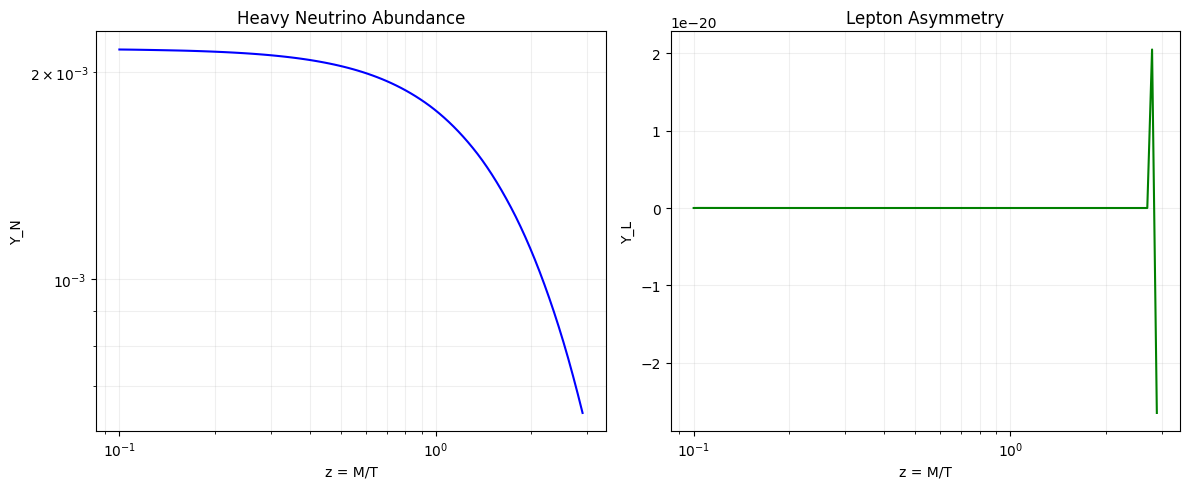

Running CP asymmetry scan with 3 values...
  Simulating with M=1.0e+13, ε=1.0e-07, K=10.0...
  Done in 0.02 seconds. Final baryon asymmetry: 3.56e-22
  Simulating with M=1.0e+13, ε=1.0e-06, K=10.0...
  Done in 0.02 seconds. Final baryon asymmetry: 9.38e-21
  Simulating with M=1.0e+13, ε=1.0e-05, K=10.0...
  Done in 0.02 seconds. Final baryon asymmetry: 6.64e-20
CP asymmetry scan completed in 0.06 seconds!


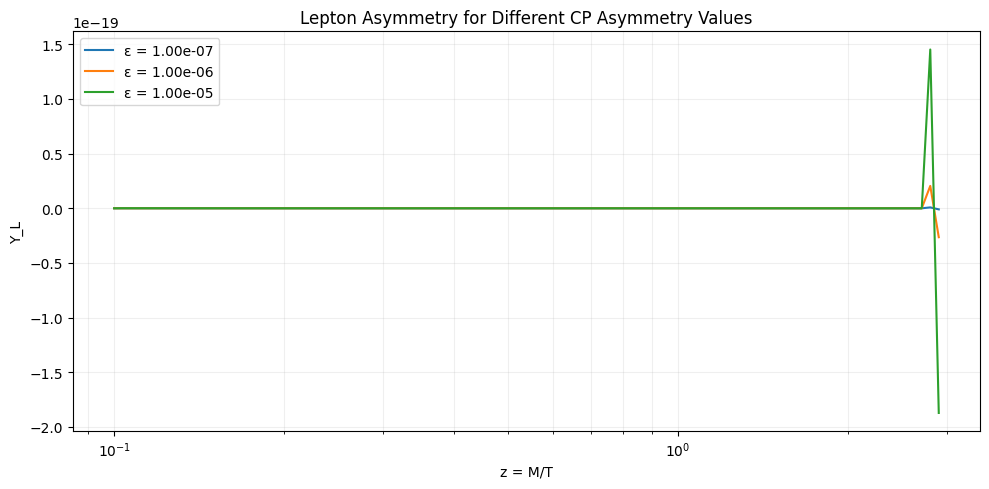

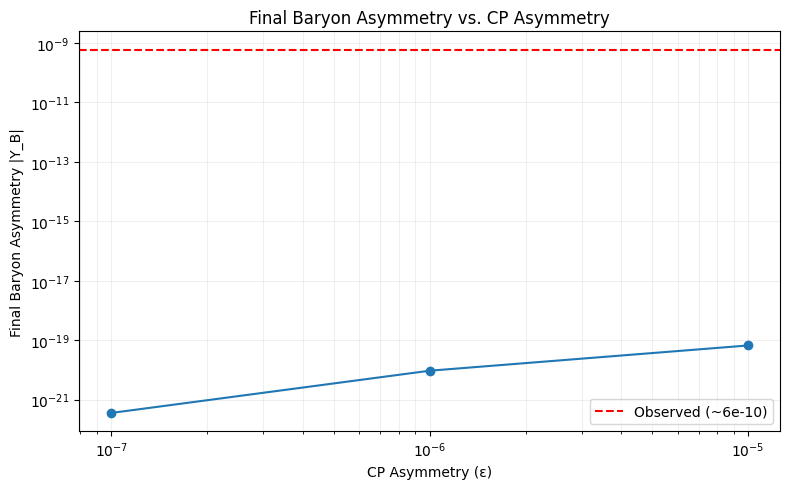

Running washout strength scan with 3 values...
  Simulating with M=1.0e+13, ε=1.0e-06, K=1.0...
  Done in 0.02 seconds. Final baryon asymmetry: -1.39e-21
  Simulating with M=1.0e+13, ε=1.0e-06, K=10.0...
  Done in 0.02 seconds. Final baryon asymmetry: 9.38e-21
  Simulating with M=1.0e+13, ε=1.0e-06, K=100.0...
  Done in 0.02 seconds. Final baryon asymmetry: -7.79e-22
Washout strength scan completed in 0.05 seconds!


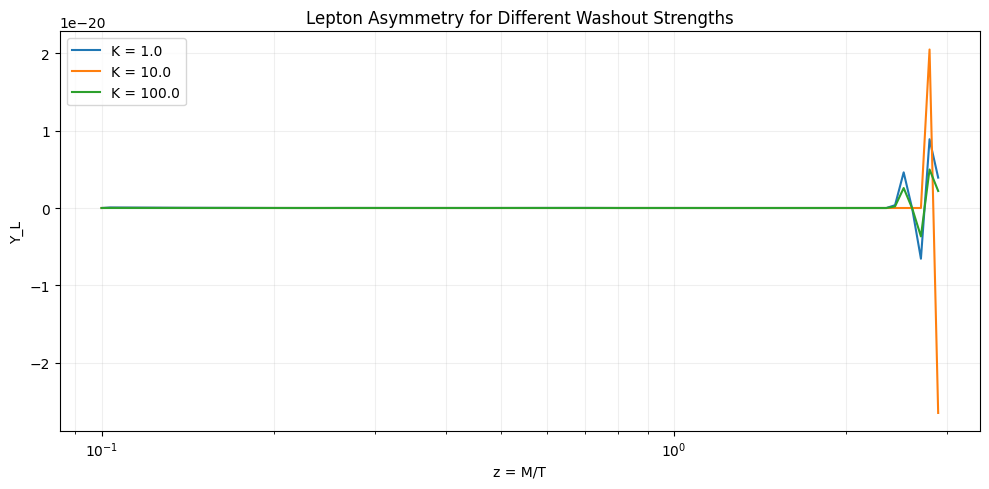

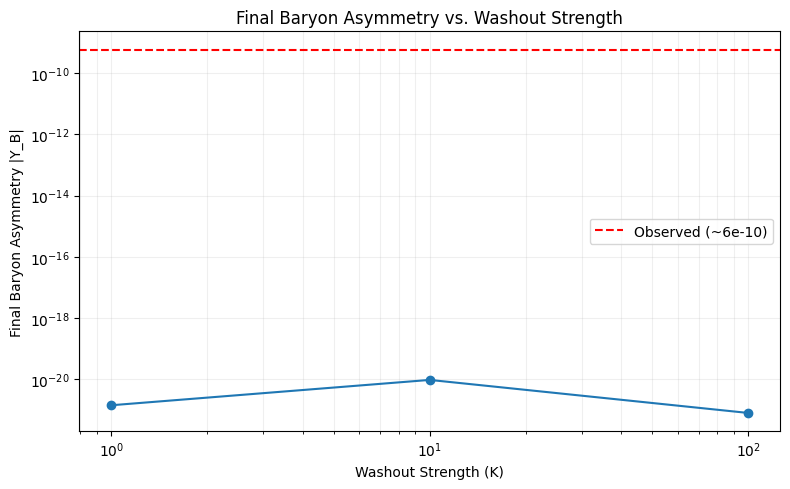

In [6]:

# Main execution
if __name__ == "__main__":
    print("\n=====================================================")
    print("FAST LEPTOGENESIS PARAMETER SCAN")
    print("=====================================================")
    print("This script has been optimized for speed!")
    print("\nWhat would you like to analyze?")
    print(" 1. Run single simulation")
    print(" 2. CP asymmetry scan")
    print(" 3. Washout parameter (K) scan")
    print(" 4. Run all analyses")
    
    choice = input("\nEnter your choice (1-4): ")
    
    if choice == "1" or choice == "4":
        print("\nRunning single leptogenesis simulation...")
        results = simulate_leptogenesis(M=1e13, epsilon=1e-6, K=10.0)
        
        # Simple plot for single simulation
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.loglog(results['z_values'], results['Y_N_values'], 'b-', label='Y_N')
        plt.xlabel('z = M/T')
        plt.ylabel('Y_N')
        plt.title('Heavy Neutrino Abundance')
        plt.grid(True, which="both", ls="-", alpha=0.2)
        
        plt.subplot(1, 2, 2)
        plt.semilogx(results['z_values'], results['Y_L_values'], 'g-', label='Y_L')
        plt.xlabel('z = M/T')
        plt.ylabel('Y_L')
        plt.title('Lepton Asymmetry')
        plt.grid(True, which="both", ls="-", alpha=0.2)
        
        plt.tight_layout()
        plt.show()
    
    if choice == "2" or choice == "4":
        quick_cp_asymmetry_scan()
    
    if choice == "3" or choice == "4":
        quick_washout_scan()